<a href="https://colab.research.google.com/github/tusker4/Sesac_Saltlux_DeepLearning/blob/main/9_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_%EC%A0%81%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 목표
- 전이학습 스타일 습득
- 파인튜닝, 기타 방식 체크
    - 업스트림 모델 신규 학습 X
    - 추가한 신경망만 학습 진행
- 데이터
    - 치매/정상 뇌 스캔 CT 사진
- 예측
    - 이진 분류
    - 치매/정산 진단 소견을 내는 주제


# 데이터
- 비전 데이터
  - 데이터가 소량 -> 이미지 부풀리기 진행
    - 단, 의료용은 배제

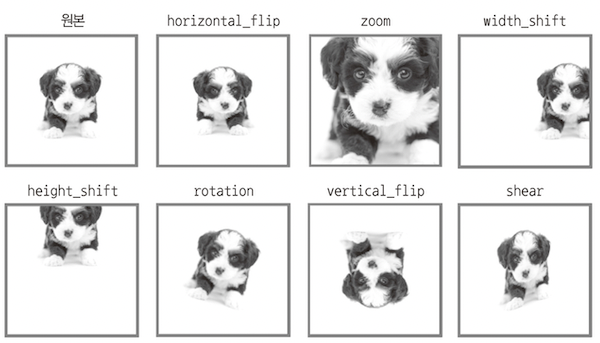

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/머신러닝(솔트룩스)/딥 러닝/전이학습/전이학습/학습_002_전이학습_데이터부플리기.png')

In [ ]:
# 데이터 공급자
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data_gen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip = True, # 수평대칭
    width_shift_range = 0.1, # 전체크기의 10% 상하좌우이동
    height_shift_range = 0.1
    # .. 나머지 부풀리기 옵션 배제

)
test_data_gen = ImageDataGenerator(rescale=1/255)


In [ ]:
# 데이터 공급원 세팅
# color_mode ='rgb' 유지, 24bit 이미지임
train_generator = train_data_gen.flow_from_directory('/content/drive/MyDrive/머신러닝(솔트룩스)/딥 러닝/data-ch20/train',
                                   target_size = (150,150),  # 이미지크기
                                   class_mode = 'binary', # 이진분류
                                   batch_size = 5         # 배치 사이즈
                                   )
test_generator = test_data_gen.flow_from_directory('/content/drive/MyDrive/머신러닝(솔트룩스)/딥 러닝/data-ch20/test',
                                  target_size = (150,150),  # 이미지크기
                                  class_mode = 'binary', # 이진분류
                                  batch_size = 5         # 배치 사이즈
                                  )

# Found 160 images belonging to 2 classes. -> 160개이미지, 2개의 분류값 체크 -> 라벨링확인
# 비전용 백본모델별 타입모두지원

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


# 인공신경망 구축
- 사전 학습된 업스트림 모델 탐색 => 다운로드
  - 탐색결과 : VGGNet 사용 (16층)
    - 2014년도 이미지인식대회 준우승
    - 옥스포드 대학 생성
    - 혁신적 구조때문에 이슈가 된 모델
- 기존 모델의 다운스트림 데이터(치매/정상 뇌스캔 사진)를 학습시켜서 모델을 생성

#3 업스트림 모델 다운로드 및 커스텀 로드

In [ ]:
# 1. 업스트림 모델 가져오기
from tensorflow.keras.applications import VGG16

In [ ]:
# 2. 업스트림 모델 생성
'''
    - include_top = True : True라면, 업스트림의 신경망의 가장 마지막층(출력층)을 포함시킨다.
                           False라면, X
    - weights = 'imagenet': imagenet => ? 이미지넷으로부터 사전학습된 모델, 그 가중치임
                            가중치를 그대로 사용한다.
    - input_shape = None  : 업스트림 모델에 훈련한 이미지가 아닌 새로운 나만의 데이터로 학습
                          => 데이터 변경됬다. => 데이터의 크기, 채널 모두 다르다 !!
                          => 다운스트림 데이터에 맞게 수정

'''

pretrained_model = VGG16(include_top = False, weights = 'imagenet', input_shape=(150, 150, 3) )

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
'''
    - 입력층에 shape이 변경된 것 확인!
    - 파라미터수 체크
    - 파라미터는 모두 훈련 가능함. 체크
    - 출력층으로 수렴하는 부분이 없다. -> include_top = False라서 그럴듯

'''

pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# 위에 출력층이없다. sigmoid추가 예정

pretrained_model.trainable = False  # 백본으로부터 내려오는 모델은 훈련X, 가중치 그대로 사용
pretrained_model.summary()          # 필요층만 건드리는 ㄴ것 도 가능


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# 다운스트림 모델 구현 - 치매 진단 모델

- 새로운 신경망을 업스트림 모델에 연결

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout

In [ ]:
fine_tuning_model = Sequential()

fine_tuning_model.add(pretrained_model)     # 사전 학습된 업스트림 모델(None, 4, 4, 512) <- block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0
fine_tuning_model.add(Flatten() )     # 4D -> 2D
fine_tuning_model.add(Dense(1024) )   # 8192 -> 1024 로 수렴 (None * 1024)
fine_tuning_model.add(Activation('relu'))   # 활성화처리
fine_tuning_model.add(Dropout(0.5))         # 과적합 방지
fine_tuning_model.add(Dense(1))             # 출력층
fine_tuning_model.add(Activation('sigmoid'))  # 이진분류 0 혹은 1로 처리

fine_tuning_model.summary()
# Trainable params: 839657 (88.14 MB)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
 activation_1 (Activation)   (None, 1)                 0

# 컴파일

In [ ]:
from typing_extensions import LiteralString
from tensorflow.keras import optimizers, metrics

fine_tuning_model.compile(optimizer = optimizers.Adam(learning_rate=0.0002),
                          loss = 'binary_crossentropy',
                          metrics = ['accuracy']
                          )


# 학습

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=5)


In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
  history = fine_tuning_model.fit(train_generator, # x, y 를 모두 제공
                                  epochs =30,
                                  callbacks = [early_stopping],
                                  validation_data = test_generator,  # 편의상 테스트용 데이터를 검증
                                  validation_steps = 10     # 검증에 사용하는 양

                                  )



Epoch 1/30
32/32 [==============================] - 29s 929ms/step - loss: 0.4627 - accuracy: 0.7750 - val_loss: 0.3927 - val_accuracy: 0.8400
Epoch 2/30
32/32 [==============================] - 16s 518ms/step - loss: 0.3180 - accuracy: 0.8687 - val_loss: 0.2461 - val_accuracy: 0.9400
Epoch 3/30
32/32 [==============================] - 12s 388ms/step - loss: 0.3192 - accuracy: 0.8438 - val_loss: 0.2546 - val_accuracy: 0.8800
Epoch 4/30
32/32 [==============================] - 7s 207ms/step - loss: 0.2100 - accuracy: 0.9312 - val_loss: 0.1926 - val_accuracy: 0.9000
Epoch 5/30
32/32 [==============================] - 7s 211ms/step - loss: 0.2155 - accuracy: 0.9000 - val_loss: 0.1466 - val_accuracy: 0.9400
Epoch 6/30
32/32 [==============================] - 2s 64ms/step - loss: 0.1903 - accuracy: 0.9250 - val_loss: 0.1880 - val_accuracy: 0.9400
Epoch 7/30
32/32 [==============================] - 4s 112ms/step - loss: 0.1605 - accuracy: 0.9438 - val_loss: 0.1380 - val_accuracy: 0.9800
Epoc

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

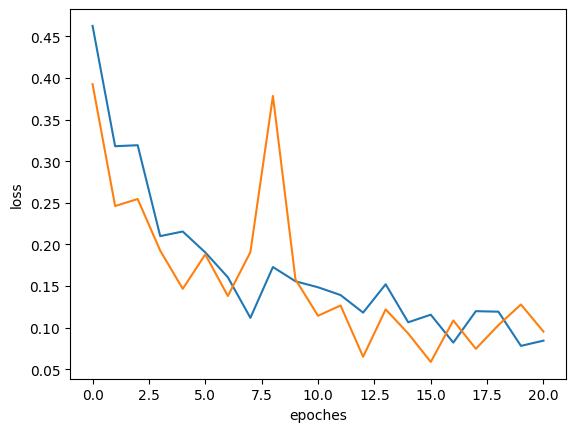

In [ ]:
# x축 : epoch, y축 손실 혹은 정확도 훈련값, 검증값

import numpy as np
import matplotlib.pyplot as plt

y_loss   = history.history['loss']
y_val_loss   = history.history['val_loss']

x = np.arange(len(y_loss))
plt.plot(x, y_loss, label = 'train_loss')
plt.plot(x, y_val_loss, label = 'val_loss')
plt.xlabel('epoches')
plt.ylabel('loss')

plt.show()